# MonaLIA Pair-Wise Odds Ratio between categories (DL training set) 

prediction scores obtained by running a model 

In [2]:
from __future__ import print_function

import os
import sys

import numpy as np
import pandas as pd

import SPARQLWrapper

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm
from sklearn import metrics

from IPython.display import display, HTML
from  textwrap import wrap

import torch
import torch.nn as nn

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

In [4]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
import MonaLIA.model.train as model
from MonaLIA.util import metadata_helpers as metadata
from MonaLIA.util import visualization_helpers as vis_helpers
from MonaLIA.data.image_dataset import JocondeDataset

importlib.reload(metadata)
importlib.reload(vis_helpers)

<module 'MonaLIA.util.visualization_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\visualization_helpers.py'>

In [3]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)
print('Pandas ver.', pd.__version__)

SPARQLWrapper ver. 1.8.5
Pandas ver. 1.0.1


In [4]:
wds_Joconde_Corese = 'http://localhost:8080/sparql'

## Query annotations

In [5]:
descr_path = 'C:/Datasets/Joconde/Forty classes'
dataset_description_file = os.path.join(descr_path, 'dataset1.csv')

annotations_df = pd.read_csv(dataset_description_file, na_filter=False)
print(annotations_df.shape)
annotations_df.head()

(85797, 12)


,Unnamed: 0,label,repr,imagePath,ref,term_count,top_term_count,terms,domain,width,height,usage
0,0,bateau,"paysage (canal, village, passerelle, barque, p...",/0093/m503501_d0109897-000_p.jpg,50350109897,1,1,barque,dessin,768,512,train
1,1,arbre+maison,"vue d'architecture (arbre, place, maison, Cour...",/0650/m080901_031011_p.jpg,M0809027797,2,2,arbre+maison,dessin,696,600,test
2,2,en buste,"portrait (Henri III, roi de Pologne, roi de Fr...",/0662/m501702_0006031_p.jpg,50170000659,1,1,en buste,estampe ; histoire,432,600,remain
3,3,nu,"figure (femme, nu, debout)",/0506/m504401_d-3861_p.jpg,50440002374,1,1,nu,dessin,266,600,remain
4,4,maison,"vue d'architecture (Angers, ville, maison, jar...",/0624/m074801_0010663_p.jpg,07480014655,1,1,maison,dessin,800,561,train


In [6]:
def my_tokenizer(s):
    return list(filter(None, set(s.split('+'))))

annotations_df.label = annotations_df.label.apply(my_tokenizer)

In [7]:
annotations_df.shape

(85797, 12)

## Create indicators columns

In [8]:
train_annotations_df = annotations_df.loc[annotations_df.usage == 'train']

annotations_dummies_df = pd.get_dummies(train_annotations_df.explode('label').label).groupby(level=0).sum()
annotations_dummies_df.columns = annotations_dummies_df.columns.str.replace(' ', '_')
annotations_dummies_df.head()

,ange,arbre,armure,bateau,bateau_à_voiles,casque,cavalier,chapeau,cheval,chien,...,oiseau,pont,robe,table,tour,uniforme,voiture_à_attelage,à_mi-corps,église,épée
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_annotations_df = train_annotations_df.merge(annotations_dummies_df,
                                      left_index=True,
                                      right_index=True)
print(annotations_df.shape)

(85797, 12)


In [10]:
corr_df = annotations_dummies_df.corr()

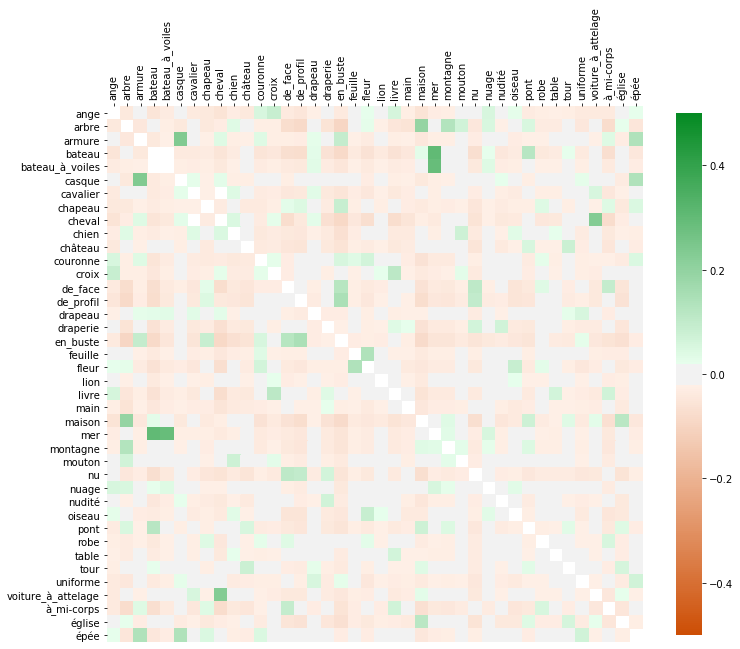

In [11]:
fig=plt.figure(figsize=(12, 12))

cmap_div = sns.diverging_palette(22, 130, s=99, n=16, as_cmap=True)

mask = corr_df >= 0.5

ax = sns.heatmap(corr_df , cmap=cmap_div,
                 mask = mask,
                 vmin=-0.5, vmax=0.5 , center =0.0,
                 square=True, cbar_kws={"shrink": 0.8})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_ticks_position('top')

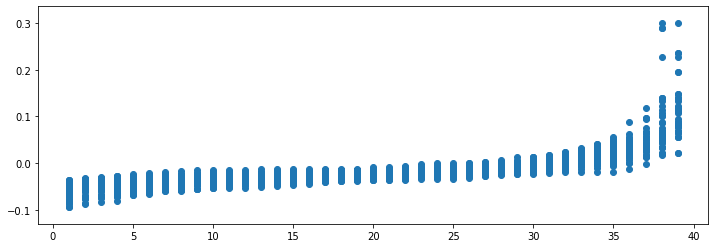

In [12]:
fig=plt.figure(figsize=(12, 4))

plt.scatter(x = corr_df[corr_df < 0.5].rank(),
            y = corr_df[corr_df < 0.5])

In [13]:
top_corr_df = corr_df.stack().reset_index()
top_corr_df.columns = ['label_A', 'label_B', 'cor']

top_corr_df = top_corr_df[(top_corr_df.cor > 0.1) & (top_corr_df.cor < 0.5)]

print(top_corr_df.shape)
top_corr_df.sort_values(by='cor', ascending=False)

(32, 3)


,label_A,label_B,cor
144,bateau,mer,0.300788
963,mer,bateau,0.300788
964,mer,bateau_à_voiles,0.289498
184,bateau_à_voiles,mer,0.289498
85,armure,casque,0.236028
202,casque,armure,0.236028
1448,voiture_à_attelage,cheval,0.228046
356,cheval,voiture_à_attelage,0.228046
63,arbre,maison,0.194454
921,maison,arbre,0.194454


In [362]:
label_A = 'mer'#'cheval'#, 'mer'
label_B = 'bateau' #'voiture à attelage'#'bateau'

label_A_ = label_A.replace(' ', '_')
label_B_ = label_B.replace(' ', '_')

In [363]:
from collections import namedtuple
Label_Stats = namedtuple('Label_Stats', ['Probs', 'Joint_prob', 'Cond_probs', 
                                         'Variance', 'Odds', 
                                         'Covariance', 'Correlation', 
                                         'PWOR'])

def calculate_stats (df, label_A, label_B, prnt=False):

    p_A = df[label_A].sum() / df.shape[0]
    p_B = df[label_B].sum() / df.shape[0]
    p_AB = (df[[label_A, label_B]].sum(axis=1) == 2).sum() / df.shape[0]
    p_A_given_B = p_AB / p_B
    p_B_given_A = p_AB / p_A

    var_A = p_A * (1-p_A)
    var_B = p_B * (1-p_B)

    odds_A = p_A /(1 - p_A)
    odds_B = p_B /(1 - p_B)

    cov_AB = p_AB - p_A*p_B
    cor_AB = cov_AB / ( np.sqrt(var_A) * np.sqrt(var_B) )
    
    pwor_AB = odds_A * ((1 - p_B_given_A) / p_B_given_A)
    pwor_BA = odds_B * ((1 - p_A_given_B) / p_A_given_B)
    
 
    if (prnt):

        print('count(%s) = %d' % ( label_A, df[label_A].sum()) )
        print('count(%s) = %d' % ( label_B, df[label_B].sum()) )
        print()
        print('P(%s) = %f' % (label_A, p_A))
        print('P(%s) = %f' % (label_B, p_B))
        print('P(%s,%s) = %f' % (label_A, label_B, p_AB))
        print()
        print('P(%s|%s) = %f' % (label_A, label_B, p_A_given_B))
        print('P(%s|%s) = %f' % (label_B, label_A, p_B_given_A))
        print()
        print('Odds(%s) = %f' % (label_A, odds_A))
        print('Odds(%s) = %f' % (label_B, odds_B))
        print()
        print('Var(%s) = %f' % (label_A, var_A))
        print('Var(%s) = %f' % (label_B, var_B))
        print()
        print('Cov(%s,%s) = %f' % (label_A, label_B, cov_AB))
        print()
        print('Cor(%s,%s) = %f' % (label_A, label_B, cor_AB))
        print()
        print('PWOR(%s|%s) = %f' % (label_A, label_B, pwor_AB))        
        print('PWOR(%s|%s) = %f' % (label_B, label_A, pwor_BA))        
        

    stats = Label_Stats( (p_A, p_B), p_AB, (p_A_given_B, p_B_given_A), (var_A, var_B), (odds_A, odds_B), cov_AB, cor_AB,
                        (pwor_AB, pwor_BA))
    return stats

stats = calculate_stats(train_annotations_df, label_A_, label_B_, prnt=True)

count(mer) = 1726
count(bateau) = 4356

P(mer) = 0.030827
P(bateau) = 0.077800
P(mer,bateau) = 0.016324

P(mer|bateau) = 0.209826
P(bateau|mer) = 0.529548

Odds(mer) = 0.031807
Odds(bateau) = 0.084363

Var(mer) = 0.029877
Var(bateau) = 0.071747

Cov(mer,bateau) = 0.013926

Cor(mer,bateau) = 0.300788

PWOR(mer|bateau) = 0.028258
PWOR(bateau|mer) = 0.317700


In [364]:
formula = '%s ~ %s' % (label_A_, label_B_)

res = sm.formula.glm(formula,  family=sm.families.Binomial(), data=train_annotations_df).fit() 
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mer   No. Observations:                55990
Model:                            GLM   Df Residuals:                    55988
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6415.1
Date:                Mon, 24 Aug 2020   Deviance:                       12830.
Time:                        17:48:15   Pearson chi2:                 5.60e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1366      0.035   -116.944      0.0

In [322]:
pd.crosstab(train_annotations_df.mer, train_annotations_df.bateau, margins=True)

bateau,0,1,All
mer,,,
0,50822,3442,54264
1,812,914,1726
All,51634,4356,55990


### Extract test set data from the annotations and from the KB

In [324]:
test_annotations_df = annotations_df.loc[annotations_df.usage == 'test']

test_annotations_dummies_df = pd.get_dummies(test_annotations_df.explode('label').label).groupby(level=0).sum()
test_annotations_dummies_df.columns = annotations_dummies_df.columns.str.replace(' ', '_')

test_annotations_df = test_annotations_df.merge(test_annotations_dummies_df,
                                                  left_index=True,
                                                  right_index=True)
test_annotations_df.shape


(4463, 52)

In [325]:
stats_test = calculate_stats(test_annotations_df, label_A_, label_B_, prnt=True)

count(mer) = 109
count(bateau) = 300

P(mer) = 0.024423
P(bateau) = 0.067219
P(mer,bateau) = 0.013220

P(mer|bateau) = 0.196667
P(bateau|mer) = 0.541284

Odds(mer) = 0.025034
Odds(bateau) = 0.072063

Var(mer) = 0.023827
Var(bateau) = 0.062701

Cov(mer,bateau) = 0.011578

Cor(mer,bateau) = 0.299550

PWOR(mer|bateau) = 0.021216
PWOR(bateau|mer) = 0.294361


In [326]:
query_image_for_test_set = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select ?ref
       ?imageURL
       ?title
       #?repr
       #?target_labels
       #?actual_labels
       #?classifier_label
       #?score
       
where 
{
    VALUES(?ref) {("%s")}

   
    ?notice jcl:noticeRef ?ref;
            jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImageUrl ?imageURL].        

    optional {?notice jcl:noticeTitr  ?title.}
}

''' #% (test_annotations_df.ref[:100].str.cat(sep = ' ' ).replace(' ', '") ("') )

In [327]:
#%time test_ext_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_image_for_test_set)
#print(test_ext_df.shape)

In [328]:
chunk_size = 100
ref_chunk_list = [test_annotations_df.ref[i:i+chunk_size] for i in range(0,test_annotations_df.ref.size, chunk_size)]

test_df = pd.DataFrame()
    
for i, ref_chunk in enumerate(ref_chunk_list):
    print(ref_chunk.size * (i+1), end=', ')
    
    chunk_query_str = query_image_for_test_set %  (ref_chunk.str.cat(sep = ' ' ).replace(' ', '") ("') )
    
    test_df = pd.concat([test_df, metadata.sparql_service_to_dataframe(wds_Joconde_Corese, chunk_query_str)], ignore_index=True)
    
print('Done')   

100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 2835, Done


In [329]:
test_annotations_df = test_annotations_df.merge(test_df, on='ref')
test_annotations_df.shape

(4463, 54)

### Run query to get image URI and Title

In [365]:
images_root = 'C:/Joconde/joconde'
multi_label = True
model_image_size = 299

dataset_mean =  [0.5, 0.5, 0.5]
dataset_std  =  [0.5, 0.5, 0.5]

batch_size = 4

test_trans = transforms.Compose([
        transforms.Resize(model_image_size),
        transforms.CenterCrop(model_image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = dataset_mean,
                             std = dataset_std),
    ])

test_set = JocondeDataset(dataset_description_file, 
                            images_root,
                            dataset_name = '40_classes',
                            label_column='label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['test']}, 
                            add_columns=['ref', 'repr'],
                            transform=test_trans)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

print('Test', test_set)
print('    Labels:', test_set.labels_count)
print()

Test Dataset JocondeDataset
    Number of datapoints: 4463
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 40
    Number of uniqie labels: 449
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
    Labels: {'ange': 178, 'arbre': 451, 'armure': 85, 'bateau': 300, 'bateau à voiles': 102, 'casque': 63, 'cavalier': 137, 'chapeau': 153, 'cheval': 374, 'chien': 183, 'château': 155, 'couronne': 155, 'croix': 119, 'de face': 237, 'de profil': 317, 'drapeau': 58, 'draperie': 177, 'en buste': 360, 'feuille': 86, 'fleur': 247, 'lion': 64, 'livre': 171, 'main': 127, 'maison': 290, 'mer': 109, 'montagne': 121, 'mouton': 56, 'nu': 277, 'nuage': 52, 'nudité': 123, 'oiseau': 219, 'pont': 112, 'robe': 62, 'table': 82, 

### Run model to obtain the scores

In [8]:
model_name = 'inception_v3'
model_checkpoint_file = os.path.abspath('../../MonaLIA/output/inception_v3_Joconde_40_classes.1000.no_sched.checkpoint.pth.tar')
checkpoint = torch.load(model_checkpoint_file)
print(checkpoint.keys())

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time'])


In [367]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print('Using cuda? ', use_cuda)

net = model.load_net(model_name = model_name, class_count=len(checkpoint['classes']))
#net.load_state_dict(torch.load(model_param_file))
net.load_state_dict(checkpoint['state_dict'])
net = net.to(device)


activation = torch.sigmoid
decision = model.decision_by_class_threshold
decision_param = checkpoint['threshold'].round(2)

scores = model.predict(net, test_loader, activation, decision, decision_param)

Using cuda?  True
images total: 1000, correct: 268, acc: 26.8% , mAP: 0.536
images total: 2000, correct: 543, acc: 27.2% , mAP: 0.539
images total: 3000, correct: 809, acc: 27.0% , mAP: 0.530
images total: 4000, correct: 1094, acc: 27.4% , mAP: 0.533
images total: 4463, correct: 1236, acc: 27.7% , mAP: 0.535
Finished prediction


In [368]:
index_A = checkpoint['classes'].index(label_A)
index_B = checkpoint['classes'].index(label_B)

scores_A_B = scores[:, [index_A, index_B]].cpu().numpy()

In [335]:
def agg_scores(x):
    _x = x#.sort_values(by='classifier_label' , ascending=True, inplace=False) 

    return pd.Series(dict(#targets = _x.iloc[0].target_labels,
                          pred_dict = dict(zip(_x['classifier_label'], _x['score'].astype(float))) 
                          #predictions = list(_x['classifier_label']),
                          #scores = list(_x['score'])
                         ))

def adjust_scores(logit_res, score_A, score_B, base_prob_B = 0.5 ):
    score_A = score_A - 0.0000001 # to prevent division by 0 for score = 1.0
    odds_pred_A = score_A / (1-score_A)
    
    pwor_A_given_B = np.exp(logit_res.params[1] * (score_B - base_prob_B))
    
    odds_pred_A_new = odds_pred_A * pwor_A_given_B
    
    score_A_new = odds_pred_A_new / (1+ odds_pred_A_new)
    
    return score_A_new

def adjust_scores_with_th(logit_res, score_A, score_B, base_prob_B = 0.5, th=0.5 ):
    score_A = score_A - 0.0000001  # to prevent division by 0 for score = 1.0
    odds_pred_A = score_A / (1-score_A)
    if (score_B > th): 
        #score_B = score_B - 0.0000001 if score_B > base_prob_B else 0.0
        pwor_A_given_B = np.exp(logit_res.params[1] * (score_B - base_prob_B))

        odds_pred_A_new = odds_pred_A * pwor_A_given_B

        score_A_new = odds_pred_A_new / (1+ odds_pred_A_new)
    else:
        score_A_new = score_A
    
    return score_A_new

In [336]:
test_df_ = pd.DataFrame.from_dict({'ref' : test_df.ref,
                                   'pred_dict' : [dict(zip( [label_A, label_B] , x )) for x in scores_A_B]})

test_df_['adjusted_score_'+label_A] = test_df_.apply(lambda x: adjust_scores_with_th(res,
                                                                      x.pred_dict[label_A],
                                                                      x.pred_dict[label_B],
                                                                       base_prob_B=0.85,
                                                                       th=0.5), axis=1 )
test_df_  = test_df_.set_index('ref') \
                    .merge(test_annotations_df.set_index('ref').loc[:, [label_A_, label_B_]] ,
                           left_index=True,
                           right_index=True) 
print(test_df_.shape)
test_df_.head()

(4463, 4)


,pred_dict,adjusted_score_mer,mer,bateau
ref,,,,
M0809027797,"{'mer': 0.019099405, 'bateau': 0.011611621}",0.0191,0,0
M0809027796,"{'mer': 0.004360502, 'bateau': 0.0006284078}",0.0044,0,0
00000107192,"{'mer': 0.0016782968, 'bateau': 0.0061286245}",0.0017,0,0
M0794019958,"{'mer': 0.0040135705, 'bateau': 0.0016089536}",0.0040,0,0
06070009050,"{'mer': 0.0003280928, 'bateau': 0.0032788971}",0.0003,0,0


In [337]:
y_true = np.array(test_df_.loc[:, [label_A_, label_B_]] , dtype = np.dtype('B')) 
y_scores =  pd.DataFrame.from_dict({label_A: test_df_.pred_dict.apply(lambda x: x[label_A]),
                                    label_B: test_df_.pred_dict.apply(lambda x: x[label_B])}).to_numpy()

AP =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores,
                                      average= None)
print('original AP', dict(zip([label_A, label_B], AP)))



y_scores_adj =  pd.DataFrame.from_dict({label_A: test_df_['adjusted_score_'+label_A],
                                    label_B: test_df_.pred_dict.apply(lambda x: x[label_B])}).to_numpy()


AP_adj =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores_adj,
                                      average= None)
print('adjusted AP', dict(zip([label_A, label_B], AP_adj)))

original AP {'mer': 0.5399737992407545, 'bateau': 0.7791617706901438}
adjusted AP {'mer': 0.5315666747075084, 'bateau': 0.7791617706901438}


Text(0.5, 1.0, ' Precision-Recall curve: bateau AP=0.78')

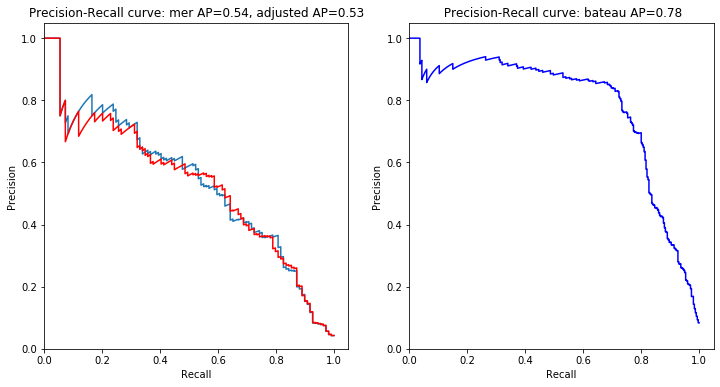

In [338]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((12,6))

precision_A, recall_A, th = metrics.precision_recall_curve(y_true[:, 0],
                                                          y_scores[:, 0])

ax1.plot(recall_A, precision_A)

precision_A_adj, recall_A_adj, _ = metrics.precision_recall_curve(y_true[:, 0],
                                                          y_scores_adj[:, 0])

ax1.plot(recall_A_adj, precision_A_adj, color='red')
ax1.set_xlim(0.0, 1.05)
ax1.set_ylim(0.0, 1.05)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall curve: {0} AP={1:0.2f}, adjusted AP={2:0.2f}'.format(label_A, AP[0], AP_adj[0]))

precision_B, recall_B, _ = metrics.precision_recall_curve(y_true[:, 1],
                                                          y_scores[:, 1])

ax2.plot(recall_B, precision_B, color='b')
#ax2.fill_between(recall_B, precision_B, alpha=0.2, color='b', step='post')
ax2.set_xlim(0.0, 1.05)
ax2.set_ylim(0.0, 1.05)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(' Precision-Recall curve: {0} AP={1:0.2f}'.format(label_B, AP[1]))

In [339]:
threshold_A =  0.9
threshold_B = 0.85

y_pred = (y_scores > np.array([threshold_A, threshold_B])).astype(dtype = np.dtype('B'))

report = metrics.classification_report(y_true= y_true,
                                         y_pred= y_pred, 
                                         target_names = [label_A, label_B])

#print(report)

print()

y_pred_adj = (y_scores_adj > np.array([threshold_A, threshold_B])).astype(dtype = np.dtype('B'))

report_adj = metrics.classification_report(y_true= y_true,
                                         y_pred= y_pred_adj, 
                                         target_names = [label_A, label_B])

#print(report_adj)

C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


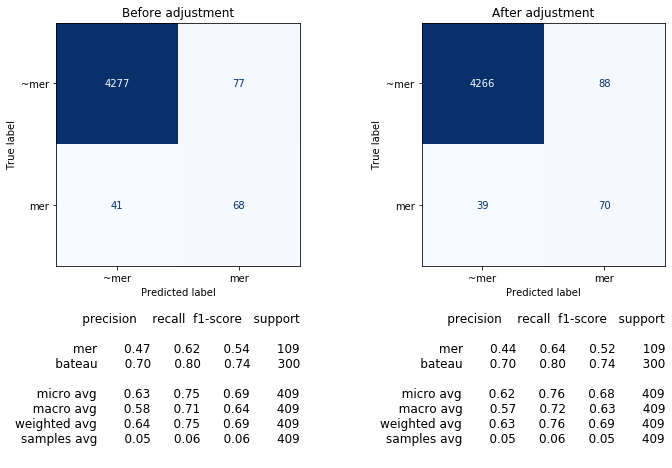

In [340]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((12,8))

cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
metrics.ConfusionMatrixDisplay(cm[0], display_labels=['~' + label_A, label_A]).plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Before adjustment')
ax1.text(1.5, 3.1, report, horizontalalignment='right', verticalalignment='bottom', fontsize=12)

cm_adj = metrics.multilabel_confusion_matrix(y_true, y_pred_adj)
metrics.ConfusionMatrixDisplay(cm_adj[0], display_labels=['~' + label_A, label_A,]).plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('After adjustment')
ax2.text(1.5, 3.1, report_adj, horizontalalignment='right', verticalalignment='bottom', fontsize=12)

plt.delaxes(fig.axes[2])
plt.delaxes(fig.axes[2])


In [341]:
def gather_row_annotation(row):
    return '\n'.join( wrap(row.title, 30 ) + 
                     [''] + 
                    wrap(row.repr, 30 ) +
                    ['',
                     '<a target="_blank" href="https://www.pop.culture.gouv.fr/notice/joconde/%s">%s</a>' % (row.ref, row.ref),
                     #'',
                    # row.imagePath
                    ])

def aggregate_group_by(x): # clean up
    _x = x#.sort_values(by='classifier_label' , ascending=True, inplace=False) 

    return pd.Series(dict(imageURL = _x.iloc[0].imageURL, 
                          info = gather_row_annotation(_x.iloc[0]), 
                          actuals=  _x.iloc[0]['actual_labels'].replace('+', '\n'),
                          targets=  _x.iloc[0]['target_labels'].replace('+', '\n'),
                          #predictions = '\n'.join(_x['classifier_label']),
                          predictions = '\n'.join(_x.iloc[0]['pred_dict'].keys()),
                          #scores = '\n'.join(_x['score'])
                          scores = '\n'.join([str(v.round(4)) for v in _x.iloc[0]['pred_dict'].values()])
                         ))

formatters_dict={'imageURL': vis_helpers.image_url_formatter,
                 'info': vis_helpers.label_formatter, 
                 'repr': vis_helpers.repr_formatter,
                 'predictions': vis_helpers.label_formatter,
                 'classifier_label':  vis_helpers.label_formatter,
                 'scores':  vis_helpers.label_formatter,
                 'actuals':  vis_helpers.label_formatter,
                 'targets':  vis_helpers.label_formatter}


In [342]:
test_view_df = test_df.set_index('ref') \
                      .merge(test_annotations_df.loc[:, ['ref','label', 'terms', 'repr']] , on='ref') \
                      .merge(test_df_.reset_index(), on='ref' )

test_view_df.rename( columns={'label': 'target_labels', 
                              'terms': 'actual_labels'}, inplace=True)

test_view_df.target_labels = test_view_df.target_labels.apply(lambda x: '+'.join(x))

In [343]:
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center') 
pd.set_option('precision', 4)

test_view_df.fillna('', inplace=True)

print(test_view_df.groupby('ref').size().shape)
print('Sample of 20 images that annotated with either "%s" or "%s"' % (label_A, label_B )  )

HTML(test_view_df.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .merge(test_df_.loc[(test_df_[label_A] + test_df_[label_B]) > 0 , ['adjusted_score_'+label_A_]], on='ref')[:20] \
                   .to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False))

(4463,)
Sample of 20 images that annotated with either "mer" or "bateau"


imageURL,info,actuals,targets,predictions,scores,adjusted_score_mer
,"VUE D'ARICIApaysage (rivière, bateau,personnage, ville)00000061444",bateau,bateau,merbateau,0.75260.9907,0.8187
,"GROUPE DE PECHEURS ASSIS SURLA PLAGE ENTRE DEUX BARQUES AL'OMBRE D'UNE VOILEscène (pêcheur : Italien,assis, bateau à voiles, plage)00000069357",bateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.99050.9994,0.9937
,"LE MARIN ; HEROISME ; LESNAUFRAGESscène (naufrage, tempête,vague, jetée, marin, homme,femme, vieux, béquille,barque, secours, héroïsme)00000074619",barque,bateau,merbateau,0.11690.2544,0.1169
,"PAYSAGE, LE PRINTEMPSpaysage (feuillu, maison,nappe d'eau, printemps) ;barque ; personnage00000074824",feuillubarquemaison,maisonbateauarbre,merbateau,0.00280.8827,0.0030
,"HALLALI DU CERF AUX ETANGS DECOMMELLEscène (chasse à courre, étang,chien, cerf, barque)00000076515",barquechien,chienbateau,merbateau,0.03940.1011,0.0394
,"VILLE HOLLANDAISE AU BORD DEL'EAUpaysage (ville, Hollande,bateau à voiles, port, ?,nuage)00000081502",bateau à voilesbateau à voilesnuage,bateau à voilesnuagebateau,merbateau,0.47430.9981,0.5777
,"PORTO D'ANZIO, COQUES SUR LAPLAGEpaysage (Porto d'Anzio, plage,bateau à voiles)00000091272",bateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.86090.7747,0.8335
,"QUATRE PECHEURS PRES DE LEURBARQUEscène (Italie, pêcheur, assis,plage, bateau à voiles)00000091280",bateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.98850.9985,0.9924
,"PAYSAGE AVEC FIGURES, BORDD'UNE RIVIEREpaysage (rivière, chaumière,tour fortifiée, feuillu, ciel); barque ; personnage00000094599",feuillubarque,bateauarbre,merbateau,0.42890.9932,0.5290
,"Un havre pour les petitsbateaux [titre attribué]paysage (port, bateau àvoiles, marin pêcheur,Côtes-d'Armor d, [sl])00000097902",bateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.68390.9994,0.7670


In [344]:
test_view_df[label_A_+'_p'] = test_view_df.pred_dict.apply(lambda x: 1 if x[label_A] > threshold_A else 0)
test_view_df[label_A_+'_ap'] = test_view_df['adjusted_score_'+label_A_].apply(lambda x: 1 if x > threshold_A else 0)


print('Changed classification for "%s"' % (label_A)  )
test_view_df_flipped = test_view_df.loc[ test_view_df[label_A+'_p'] != test_view_df[label_A_+'_ap'], :]

#print('Classification False Positives for "%s"' % (label_A)  )
#test_view_df_flipped = test_view_df_flipped.loc[ (test_view_df_flipped[label_A] == 0) & (test_view_df_flipped[label_A+'_p'] == 1), :]


Changed classification for "mer"


In [345]:
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center') 
pd.set_option('precision', 4)

#test_view_df_flipped.fillna('', inplace=True)

print(test_view_df_flipped.groupby('ref').size().shape)
HTML(test_view_df_flipped.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .reset_index() \
                   .set_index('ref') \
                   #.merge(test_df_.loc[:, ['adjusted_score_A']], left_index=True, right_index=True) \
                   .merge(test_view_df_flipped.loc[:, ['ref', 'adjusted_score_'+label_A, label_A, label_A+'_p', label_A+'_ap']].set_index('ref'), left_index=True, right_index=True) \
                   .drop_duplicates() \
                   .sort_values(by=[label_A, label_A+'_p', label_A+'_ap'])
                   .to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False, 
                        show_dimensions=True))

(19,)


imageURL,info,actuals,targets,predictions,scores,adjusted_score_mer,mer,mer_p,mer_ap
,"Paimpol : les bateaux à maréebasse [titre attribué]paysage (bord de mer, bateau,pêche aux engins, marinpêcheur, rocher, phare,Paimpol)00000097973",bateau,bateau,merbateau,0.87460.9991,0.9139,0,0,1
,"bateaux de pêche dans l'ansede Camaret [titre attribué]paysage (port, bateau, filet,marin pêcheur, Camaret-sur-Mer)00000098310",bateau,bateau,merbateau,0.85670.9991,0.9009,0,0,1
,"Moulin de Mordreuc [titreattribué]paysage (estuaire, Rance fl,marée basse, berge, forêt,moulin à eau, barque,Pleudihen-sur-Rance)00000101794",barque,bateau,merbateau,0.86820.9912,0.9073,0,0,1
,"Marinepaysage (bord de mer, rocher,voilier) ; marin pêcheur000PE023215",bateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.89470.9962,0.9276,0,0,1
,"Paysage fluvialpaysage (fleuve, barque,bateau à voiles, )00190022572",barquebateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.87690.9983,0.9153,0,0,1
,"Marinepaysage (port, voilier,barque, marin)01550012380",barquebateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.87790.9995,0.9163,0,0,1
,"Omonville, naufrage de l'IOWAscène (Seine-Maritime d,Omonville-la-Rogue, bord demer, foule, barque, bateau àmoteur)06770008488",bateau à moteurbarque,bateau,merbateau,0.88420.9996,0.9208,0,0,1
,"Le Bassin de l'Eure au Havrepaysage (Le Havre, bateau àvoiles, crépuscule, soleil)07030000148",bateau à voilesbateau à voiles,bateau à voilesbateau,merbateau,0.89850.9981,0.9307,0,0,1
,"(temple, arbre, autel, coeur :flamme, amour,carquois)#(femme, debout,plateau)07120003785",arbre,arbre,merbateau,0.8850.9818,0.9176,0,0,1
,"paysagepaysage, scène, figure(chinois, plante exotique,arbre, palmier, rivière,barque)10230000618",arbrepalmierbarque,bateauarbre,merbateau,0.87380.9875,0.9106,0,0,1


In [346]:
#save to a file
test_view_df_flipped.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .reset_index() \
                   .set_index('ref') \
                   .merge(test_view_df_flipped.loc[:, ['ref', 'adjusted_score_'+label_A, label_A, label_A+'_p', label_A+'_ap']].set_index('ref'), left_index=True, right_index=True) \
                   .drop_duplicates() \
                   .sort_values(by=[label_A, label_A+'_p', label_A+'_ap']) \
                   .to_html( buf='results of adjusting scores of mer by bateau.html',
                        formatters=formatters_dict, 
                        escape=False,
                        index=False, 
                        show_dimensions=True)

# Scrapbook

In [206]:
test_df_['score_'+ label_A_] = test_df_.pred_dict.apply(lambda x: x[label_A])
test_df_['score_'+ label_B_] = test_df_.pred_dict.apply(lambda x: x[label_B])

In [223]:
import statsmodels.api as sm

res = sm.formula.glm("mer ~ score_mer",  family=sm.families.Binomial(), 
                     data=test_df_).fit() 
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mer   No. Observations:                 4463
Model:                            GLM   Df Residuals:                     4461
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -272.45
Date:                Thu, 20 Aug 2020   Deviance:                       544.90
Time:                        19:24:31   Pearson chi2:                 4.17e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7841      0.258    -22.403      0.0

In [396]:
print("Coefficeients")
print(res.params)
print()
print("p-Values")
print(res.pvalues)
print()
print("Dependent variables")
print(res.model.endog_names)

Coefficeients
Intercept   -4.438906
bateau       3.146720
dtype: float64

p-Values
Intercept    0.0
bateau       0.0
dtype: float64

Dependent variables
mer


In [399]:
x = pd.DataFrame.from_dict({'bateau': [0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]})

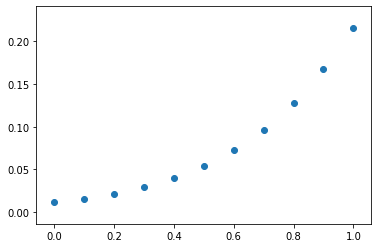

In [400]:
res_pred = pd.Series(res.predict(x, transform=True)) #.apply(lambda s: 1 / (1+ np.exp(-s)))
plt.scatter(x = x,
            y = res_pred)